# Phase dynamics and visual feedback

In this notebook, we will build upon the previous quantifications on the relationship between phase and directional swimming and see whether visual feedback is necessary / involved in the rotation of the network.

In [1]:
from scipy.stats import wilcoxon
from tqdm import tqdm

In [9]:
%matplotlib widget

import lotr.plotting as pltltr
import numpy as np
import pandas as pd
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment, dataset_folders
from lotr.behavior import get_fictive_heading
from lotr.utils import crop, interpolate, linear_regression, resample_matrix
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon
from tqdm import tqdm

COLS = pltltr.COLS

## Load stimulus information

We will use the `LotrExperiment.stim_trials_df` method to load from each experiment a dictionary describing the sequence of stimuli and the concatenate all of them in a single dataframe.
The `all_stim_conds` will contain a `condition` column that can be one of the following:
 - **`darkness`**: black screen, fish swimming in the darkness
 - **`closed_loop`**: fish experiences visual feedback when moving. This consists in a pink noise pattern that, every time the fish performa a bout, rotates proportionally to the laterality index for the bout (with inverted sign), and translates backward up with an average speed of approx. 10 mm/s. In the gainmod experiments, a gain factor that changes the amount of rotation  induced by each directional bout is alternated between 0.5 (**low gain**), 1.0 (**normal gain**), 2.0 (**high gain**), -1 (**inverted motion**).
 - **`natural_mot`**: pink noise that is translated/rotated independently of the fish motion in ways similar to what the fish would experience swimming over the pattern - a sort of playback of a closed loop experiment. This stimulus induces very small responses in visual directional motion/rotation cells as every movement is very brief.
 - **`directional_mot`**: pink noise that moves in 8 equally spaced directions on the plane below the fish in periods of 10s, spaced by pause periods of 10s where the pattern is static. As the fish is mostly moving during directional motion, for the sake of this quantification for now all bouts during both the motion and the static times are pooled in the "directional_mot" condition # TODO maybe split them

In [3]:
all_stim_logs = [LotrExperiment(path).stim_trials_df for path in tqdm(dataset_folders)]
all_stim_conds = pd.concat(all_stim_logs, ignore_index=True, sort=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.47it/s]


### Visualize all experiment types

Let's have a quick look at all the experiment types:

NameError: name 'COLS' is not defined

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
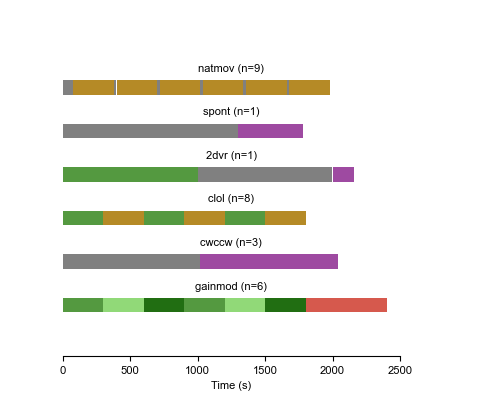

In [4]:
all_exp_types = all_stim_conds.exp_type.unique()

f, axs = plt.subplots(
    len(all_exp_types) + 1,
    1,
    figsize=(5, 4),
    gridspec_kw=dict(top=0.8, right=0.8, hspace=2),
)
for i, exp_type in enumerate(all_exp_types):
    # Get an example fish for the experiment:
    fids = all_stim_conds.loc[all_stim_conds["exp_type"] == exp_type, "fid"].unique()
    fid = fids[0]

    # Plot with custom lotr function:
    pltltr.plot_exp_condition(
        all_stim_conds[all_stim_conds["fid"] == fid], ax=axs[i], alpha=1
    )

    axs[i].set(title=exp_type + f" (n={len(fids)})", xlim=(0.0, 2500))

for ax in axs[:-1]:
    pltltr.despine(ax, "all")
pltltr.despine(axs[-1], ["left", "top", "right"])

axs[-1].set(xlabel="Time (s)", xlim=(0.0, 2500))

ax = f.add_axes((0.75, 0.95, 0.2, 0.2))
ax.axis("off")
v_space = -0.17
v_o, h_o = 0, 0.01

for text, item in COLS["stim_conditions"].items():
    lab = " ".join(text.split("_")).capitalize()
    if text != "closed_loop":
        ax.text(h_o, v_o, lab, c=item, weight="bold", fontsize=8)
        v_o += v_space
    else:
        for g, col in item.items():
            ax.text(h_o, v_o, f"{lab} (gain {g})", c=col, weight="bold", fontsize=8)
            v_o += v_space

pltltr.savefig("experiment_types")

## Bout-induced phase changes w/ and w/o visual feedback 

First of all, we crop phase shifts and cumulative theta turned around all bouts as we did in the previous notebook. Then, for every bout we will add a label specifying what was the ongoing stimulus at its onset time:

In [6]:
from lotr.analysis.shift_cropping import crop_shifts_all_dataset
from lotr.default_vals import (
    DEFAULT_FN,
    POST_BOUT_WND_S,
    PRE_BOUT_WND_S,
    WND_DELTA_PHASE_S,
)

(
    all_phase_cropped,
    all_head_cropped,
    all_stim_cropped,
    events_df,
    time_arr,
) = crop_shifts_all_dataset(crop_stimulus=True)

# TODO: fix this misnaming in actual preprocessing
events_df.loc[events_df["fid"] == "210601_f0_2d_vr_eyes", "fid"] = "210601_f0_2dvr_eyes"

# add label for condition and gain to every bout:
events_df["condition"] = "-"
events_df["gain"] = np.nan

for i in tqdm(events_df.index):
    sel_trial = (
        (all_stim_conds["t_start"] < events_df.loc[i, "t_start"])
        & (all_stim_conds["t_stop"] > events_df.loc[i, "t_start"])
        & (all_stim_conds["fid"] == events_df.loc[i, "fid"])
    )
    events_df.loc[i, "condition"] = all_stim_conds.loc[sel_trial, "condition"].values
    events_df.loc[i, "exp_type"] = all_stim_conds.loc[sel_trial, "exp_type"].values

    if events_df.loc[i, "condition"] == "closed_loop":
        events_df.loc[i, "gain_theta"] = all_stim_conds.loc[
            sel_trial, "gain_theta"
        ].values

# Calculate amount of shift around each motor event:
wnd_pts = (PRE_BOUT_WND_S + WND_DELTA_PHASE_S) * DEFAULT_FN
events_df["delta_phase"] = np.nanmean(all_phase_cropped[slice(*wnd_pts), :], 0)
events_df["delta_head"] = np.nanmean(all_head_cropped[slice(*wnd_pts), :], 0)

100%|█████████████████████████████████████████████████████████████████████████████| 8333/8333 [00:15<00:00, 546.14it/s]


### Effects of gain modulation

Now, for `gainmod` experiments, we can calculate whether gain has an effect on peri-event heading-to-phase correlation

In [7]:
MIN_BOUTS_N = 10  # minimum number of bouts to compute regression
gains = [0.5, 1, 2, -1]  # fix sequence for consistency

# select gainmod stimuli:
gainmod_df = events_df[events_df["exp_type"] == "gainmod"]
gain_results_df = []

if len(gainmod_df) > 0:
    for fid in gainmod_df["fid"].unique():
        gdict = dict(fid=fid)
        for g in gains:
            sel_df = events_df[
                (events_df["gain_theta"] == g)
                & (events_df["fid"] == fid)
                & ((events_df["direction"] == "rt") | (events_df["direction"] == "lf"))
            ]
            if len(sel_df) > MIN_BOUTS_N:
                _, corr = linear_regression(sel_df["delta_phase"], sel_df["delta_head"])
            else:
                corr = np.nan
            gdict[g] = corr
            # results_df.append({"gain": g, "fid": fid, "corr": corr})
        gain_results_df.append(gdict)

    gain_results_df = pd.DataFrame(gain_results_df).set_index("fid")

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
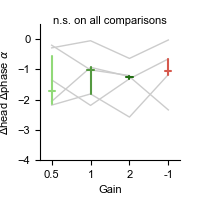

In [20]:
if len(gainmod_df) > 0:
    cols = [c for _, c in COLS["stim_conditions"]["closed_loop"].items()]

    f, ax = plt.subplots(figsize=(2.0, 2), gridspec_kw=dict(left=0.2, bottom=0.2))
    pltltr.tick_with_bars(
        gain_results_df, cols=cols, lw=1.5, s=0.08,
    )
    plt.plot(gain_results_df.values.T, lw=1, c=".8")
    ax.set(
        ylabel=(r"Δhead Δphase $\alpha$"),
        xlabel="Gain",
        xticks=[0, 1, 2, 3],
        xticklabels=[0.5, 1, 2, -1],
        xlim=(-0.3, 3.3),
        ylim=(-4, 0.5),
    )
    pltltr.despine(ax)

    # run all possible pair-wise tests:
    all_res = []
    for i in range(len(gains)):
        for j in range(i + 1, len(gains)):
            test_res = wilcoxon(*[gain_results_df[k] for k in [gains[i], gains[j]]])
            all_res.append(test_res.pvalue)

    ax.text(
        1.5,
        0.5,
        pltltr.get_pval_stars(min(all_res)) + " on all comparisons",
        ha="center",
    )

    pltltr.savefig("different_gains_comparison")

There seem to be no effect of the gain!

### Effects of closed- vs. open-loop stimuli

In [11]:
# Select fish that have closed loop:
# included_fish = events_df.loc[events_df["condition"] == "closed_loop", "fid"].unique()
included_fish = events_df.loc[events_df["exp_type"] == "clol", "fid"].unique()


clol_results_df = []
for fid in included_fish:
    gdict = dict()
    for cl_sel, k in zip(
        [
            (events_df["condition"] == "closed_loop"),
            (events_df["condition"] != "closed_loop"),
        ],
        ["cl", "ol"],
    ):
        sel_df = events_df[cl_sel & (events_df["fid"] == fid)]
        if len(sel_df) > 10:
            _, corr = linear_regression(sel_df["delta_phase"], sel_df["delta_head"])
        else:
            corr = np.nan
        gdict[k] = corr

    clol_results_df.append(gdict)
clol_results_df = pd.DataFrame(clol_results_df).dropna()

meta NOT subset; don't know how to subset; dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
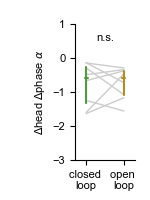

In [22]:
if len(clol_results_df) > 0:
    cols = [
        COLS["stim_conditions"]["closed_loop"][1],
        COLS["stim_conditions"]["natural_motion"],
    ]

    f, ax = plt.subplots(figsize=(1.5, 2), gridspec_kw=dict(left=0.5, bottom=0.2))
    pltltr.tick_with_bars(
        clol_results_df, cols=cols, lw=1.5,
    )
    plt.plot(clol_results_df.values.T, lw=1, c=".8")
    ax.set(
        ylabel=(r"Δhead Δphase $\alpha$"),
        xticks=[0, 1],
        xticklabels=["closed \nloop", "open \nloop"],
        xlim=(-0.3, 1.3),
        ylim=(-3, 1),
    )
    test_res = wilcoxon(*[clol_results_df[k] for k in ["cl", "ol"]])
    ax.text(0.5, 0.5, pltltr.get_pval_stars(test_res), ha="center")
    pltltr.despine(ax)

    pltltr.savefig("cl_ol_comparison")

Also closed vs. open loop does not really seem to have any effect!

# Phase bout-triggered averages in closed loop experiments

C:\Users\lpetrucco\miniconda3\envs\lotr\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\lpetrucco\miniconda3\envs\lotr\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\lpetrucco\miniconda3\envs\lotr\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\lpetrucco\miniconda3\envs\lotr\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
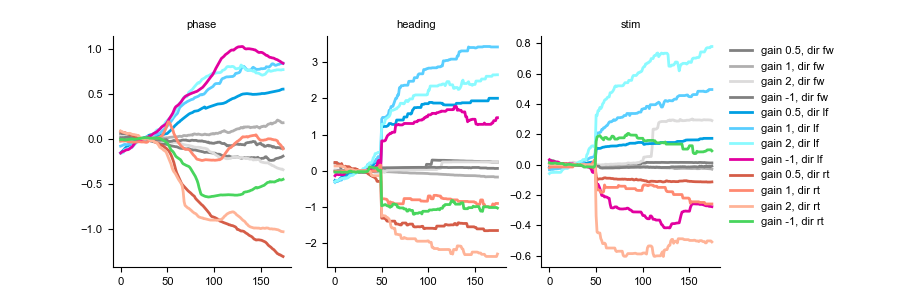

In [17]:
if all_stim_cropped is not None:
    included_fish = events_df.loc[events_df["exp_type"] == "gainmod", "fid"].unique()
    # clol_results_df = []

    f, axs = plt.subplots(1, 3, figsize=(9, 3), gridspec_kw=dict(right=0.8))

    for d in ["fw", "lf", "rt"]:
        for gain, lum_c in zip(
            [0.5, 1, 2, -1],
            [pltltr.shift_lum(COLS["sides"][d], s) for s in [0, 0.2, 0.4]]
            + [np.array(COLS["sides"][d])[[2, 0, 1]],],
        ):
            avgs = [[], [], []]
            for fid in included_fish:
                sel_df = events_df[
                    (events_df["gain_theta"] == gain)
                    & (events_df["direction"] == d)
                    & (events_df["fid"] == fid)
                ]
                # plt.plot(np.nanmean(all_phase_cropped[:, sel_df.index], 1), c=COLS["sides"][d], lw=0.5)
                # avgs.append(np.nanmean(all_phase_cropped[:, sel_df.index], 1))
                # if len()
                if len(sel_df) > 5:
                    for i, to_crop in enumerate(
                        [all_phase_cropped, -all_head_cropped, all_stim_cropped]
                    ):
                        avgs[i].append(np.nanmedian(to_crop[:, sel_df.index], 1))
                        # avgs = np.nanmean(
                        #    to_crop[:, sel_df.index], 1
                        # np.nanmean(np.array(avgs), 0)

            for i, (ax, title) in enumerate(zip(axs, ["phase", "heading", "stim"])):
                ax.plot(
                    np.nanmean(avgs[i], 0), c=lum_c, lw=2, label=f"gain {gain}, dir {d}"
                )
                pltltr.despine(ax)
                ax.set_title(title)

            axs[2].legend(loc=2, bbox_to_anchor=(1, 1))

C:\Users\LPETRU~1\AppData\Local\Temp/ipykernel_21476/1278600444.py:14: RuntimeWarning: Mean of empty slice
  avgs.append(np.nanmean(all_head_cropped[:, sel_df.index], 1))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
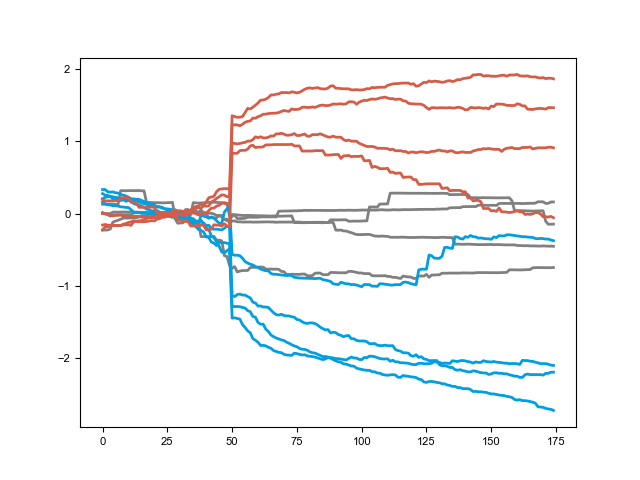

In [18]:
if all_stim_cropped is not None:
    included_fish = events_df.loc[events_df["exp_type"] == "gainmod", "fid"].unique()
    # clol_results_df = []
    plt.figure()
    for d in ["fw", "lf", "rt"]:
        for gain in [0.5, 1, 2, -1]:
            avgs = []
            for fid in included_fish:
                sel_df = events_df[
                    (events_df["gain_theta"] == gain)
                    & (events_df["direction"] == d)
                    & (events_df["fid"] == fid)
                ]
                # plt.plot(np.nanmean(all_phase_cropped[:, sel_df.index], 1), c=COLS["sides"][d], lw=0.5)
                avgs.append(np.nanmean(all_head_cropped[:, sel_df.index], 1))

            avgs = np.nanmean(np.array(avgs), 0)
            plt.plot(avgs, c=COLS["sides"][d], lw=2)

C:\Users\LPETRU~1\AppData\Local\Temp/ipykernel_21476/3054945643.py:14: RuntimeWarning: Mean of empty slice
  avgs.append(np.nanmean(all_phase_cropped[:, sel_df.index], 1))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
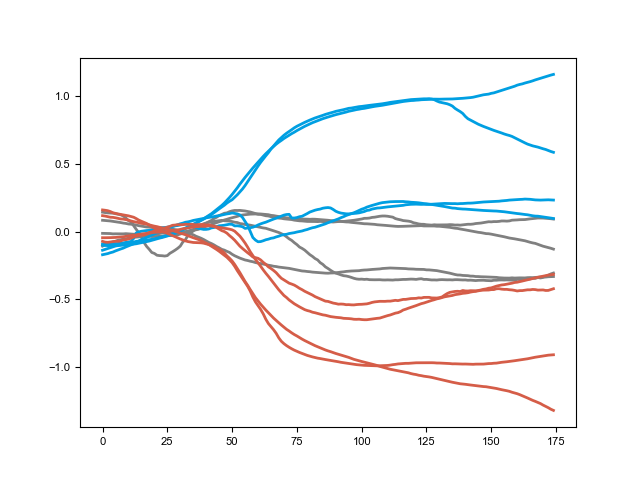

In [19]:
if all_stim_cropped is not None:
    included_fish = events_df.loc[events_df["exp_type"] == "gainmod", "fid"].unique()
    # clol_results_df = []
    plt.figure()
    for d in ["fw", "lf", "rt"]:
        for gain in [0.5, 1, 2, -1]:
            avgs = []
            for fid in included_fish:
                sel_df = events_df[
                    (events_df["gain_theta"] == gain)
                    & (events_df["direction"] == d)
                    & (events_df["fid"] == fid)
                ]
                # plt.plot(np.nanmean(all_phase_cropped[:, sel_df.index], 1), c=COLS["sides"][d], lw=0.5)
                avgs.append(np.nanmean(all_phase_cropped[:, sel_df.index], 1))

            avgs = np.nanmean(np.array(avgs), 0)
            plt.plot(avgs, c=COLS["sides"][d], lw=2)

In [ ]:
plt.plot(avgs.T)
plt.show()

In [ ]:
plt.figure()
plt.plot()